In [ ]:
%load_ext autoreload
%autoreload 2

import re
from pathlib import Path

PROJECT_DIR = '/workspace/current/loce'
import sys

sys.path.append(PROJECT_DIR)

import pandas as pd
pd.set_option('display.max_rows', 1000)
import itertools

from bg_randomized_loce.utils.eval_util import plot_means, calc_ious_global, IoUEvalConfig
from bg_randomized_loce.utils.loce_storage_helpers import df_from_csv, df_where_cols_equal

bg_randomized_loce.utils.consts.PROJECT_DIR = PROJECT_DIR

from tqdm.notebook import tqdm

from IPython.display import display



## Preparation

In [172]:
csv_cache = os.path.join(PROJECT_DIR, 'data/results/predictions')
if os.path.isfile(os.path.join(csv_cache, 'results.csv')):
    print("Loading from common file ...")
    ious = df_from_csv(os.path.join(csv_cache, 'results.csv'))
else:
    csv_files = list(Path(csv_cache).glob('**/results_*.csv'))
    if len(csv_files) > 0:
        print("Loading from file fragments ...")
        ious_list = []
        for csv_path in tqdm(csv_files):
            ious_list.append(df_from_csv(csv_path))
        ious = pd.concat(ious_list, axis=0, ignore_index=True)
    else:
        print("Regenerating ...")
        ious, errs = await calc_ious_global(IoUEvalConfig(results_dir=os.path.join(PROJECT_DIR, 'results'), verbose=2))
[print(c, ":", ious[c].unique()) for c in ious.columns if c not in ('loss', 'iou', 'img_id', 'test_img_id') and 'path' not in c];

# add some layer infos
ious['depth'] = 'unknown'  # some default
for depth, layers in LAYERS_BY_DEPTH.items():
    ious['depth'] = ious['depth'].mask(ious[LAYER].isin(layers), depth)

Loading from common file ...


/workspace/current/loce/experiments/helpers.py:386: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  plain_df = pd.read_csv(csv_path)


global_or_local : ['global' 'local_to_global']
run : ['run1']
ce_method : ['net2vec_proper_bce' 'globalized_loce_proper_bce']
bg_randomizer_key : ['vanilla' 'places' 'places_voronoi' 'synthetic']
num_bgs_per_ce : [ 1  4 32  8]
dataset_key : ['pascal_voc' 'imagenets50']
model_key : ['efficientnet' 'vit' 'detr' 'yolo' 'swin' 'mobilenet' 'vgg']
category_id : [ 1  2  3  4  5  6  7  8  9 16 17 18 19 20 10 11 12 13 14 15 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
layer : ['features.4.2' 'features.6.0' 'features.7.0' 'conv_proj'
 'encoder.layers.encoder_layer_6' 'encoder.layers.encoder_layer_11'
 'model.backbone.conv_encoder.model.layer4' 'model.input_projection'
 'model.encoder.layers.5' '4.cv3.conv' '14.conv' '23.cv3.conv'
 'features.0' 'features.3' 'features.7' 'features.7.block.2.0'
 'features.12.block.3.0' 'features.16.0' 'features.21' 'features.28']
test_img_subid : [0 1 2 3]
test_bg_key : ['vanilla' 'architecture' 'indoors' 'at_water' '

### Influence of Layer Depth
How does the average performance evolve over layers? -> Later = better

In [173]:
# Print mean and standard deviation of the IoU by depth and ce method
pivoted = pd.pivot_table(ious, values='iou', 
                         index=CE_METHOD, columns=DEPTH, 
                         aggfunc=['mean', 'std']
                         ).sort_index(axis=1, level=1, key=lambda xs: [['early', 'middle', 'late'].index(x) for x in xs])
display(pivoted)
print(pivoted.style.to_latex())
print(pivoted.mean())


,mean,std,mean,std,mean,std
depth,early,early,middle,middle,late,late
ce_method,,,,,,
globalized_loce_proper_bce,0.255387,0.266178,0.392815,0.264777,0.440764,0.252960
net2vec_proper_bce,0.221492,0.236272,0.376831,0.259234,0.412410,0.264799


\begin{tabular}{lrrrrrr}
 & mean & std & mean & std & mean & std \\
depth & early & early & middle & middle & late & late \\
ce_method &  &  &  &  &  &  \\
globalized_loce_proper_bce & 0.255387 & 0.266178 & 0.392815 & 0.264777 & 0.440764 & 0.252960 \\
net2vec_proper_bce & 0.221492 & 0.236272 & 0.376831 & 0.259234 & 0.412410 & 0.264799 \\
\end{tabular}

      depth 
mean  early     0.238440
std   early     0.251225
mean  middle    0.384823
std   middle    0.262005
mean  late      0.426587
std   late      0.258879
dtype: float64


## Influence of #BG Images
Does performance improve with increasing number of bg randomized image variants per foreground?
-> No. The effect is only ever so slightly and insignificant; by far not justifying the additional effort.
This nicely indicates again that this truly is a few shot method.


Average IoU values (here: last layer) of vanilla-trained CEs are slightly worse for randomized-testing, and vice versa. The drop is not severe, though, indicating that there is only little domain shift, even between synthetic and realistic backgrounds.

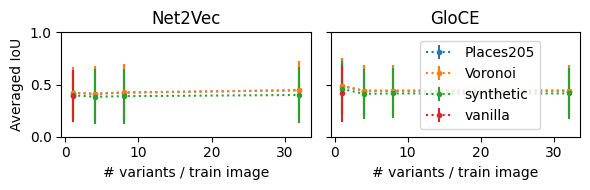

In [195]:
#plot_means(ious, value='iou', group_cols=[MODEL], compare=['depth'])
#plot_means(ious, value='iou', group_cols=[BG], compare=['depth'])
#plot_means(ious, value='iou', group_cols=[CAT], compare=['depth'])

fig, means, stds = plot_means(ious, restrict_to={DEPTH: 'late'},
        values='iou',
        compare=[BG], group_cols=[NUM_BG],
        side_by_side=[CE_METHOD], #top_to_bottom=[MODEL],
        ylim=[0, 1],
        pretty_names={**PRETTY_NAMES, BG: "Trained with",},
        kind='line', linestyle='dotted', marker='.', legend=False,
        ylabel="Averaged IoU", xlabel="# variants / train image",
        axsize=(3,2),
        )
fig.axes[1].legend(loc='center', bbox_to_anchor=(.6, .5))
for ax, ce_method in zip(fig.axes, ious[CE_METHOD].unique()):
    ax.set_title(PRETTY_NAMES.get(ce_method, ce_method))
#fig.suptitle("Influence of # of variants")
fig.tight_layout()
fig.savefig(os.path.join(PROJECT_DIR, 'data/results/resources/iou-num-bgs.pdf'))


## Comparing Test IoU
General comparison of averaged IoU on bg-randomized and vanilla test data, with or without bg-randomized pretraining.

In [164]:
## Mean performances
display(pd.pivot_table(
    df_where_cols_equal(ious[ious[TEST_BG].isin((VANILLA, 'any'))], {NUM_BG: 1, DEPTH: 'late'}),
    values=IOU,
    index=[DATA, TEST_BG], columns=[CE_METHOD, BG],
    aggfunc=['mean', 'std']
).swaplevel(2,0, axis=1).swaplevel(1,0,axis=1).sort_index(axis=1, level=[0,1])
.style.highlight_max(subset=(slice(None), (slice(None), slice(None), 'mean')), axis=1)
)
    


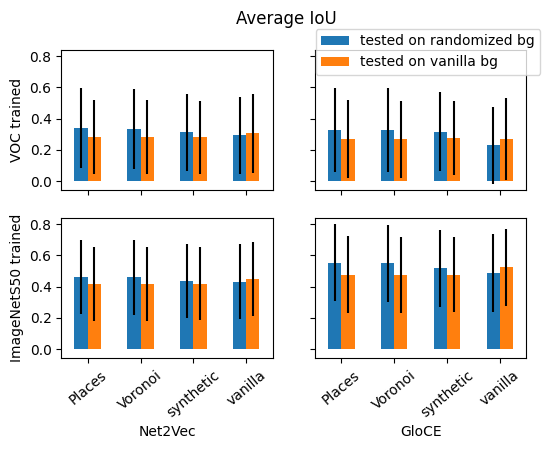

In [152]:
to_plot = ious[ious[TEST_BG].isin((VANILLA, 'any'))]
to_plot.loc[:, TEST_BG] = to_plot[TEST_BG].replace('vanilla', 'vanilla_tested')
fig, means, std = plot_means(to_plot, restrict_to={NUM_BG: 1, DEPTH: 'late'},
    values=IOU,
    compare=[TEST_BG], group_cols=[BG],
    side_by_side=[CE_METHOD],
    top_to_bottom=[DATA,],# DEPTH]
    legend=False,
    pretty_names={**PRETTY_NAMES, 'pascal_voc': "VOC trained", 'imagenets50': "ImageNetS50 trained", "places": "Places", "any": "tested on randomized bg", "vanilla_tested": "tested on vanilla bg"},
    axsize=(3,2),
    rot=40
)
fig.suptitle("Average IoU")
fig.axes[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.2)) #outside upper right
# plt.tight_layout()
fig.show()
os.makedirs(os.path.join(PROJECT_DIR, 'data/results/resources/'), exist_ok=True)
fig.savefig(os.path.join(PROJECT_DIR, 'data/results/resources/iou-test-vanilla-vs-rand.pdf'), bbox_inches='tight')


## Identifying Concept-to-Background Biases
For which combinations of concepts and backgrounds can we find a severe drop / increase in IoU performance of the vanilla models compared to
- the background randomized trained models?
- the performance on the vanilla test dataset?
- the performance on testing on arbitrary (randomized) backgrounds?

Have a look at influence of
- CE method
- training/testing concept dataset
- model architecture / training dataset

In [208]:
restrict_to = {
    BG: VANILLA,
    NUM_BG: 1,  # not much of a difference
    DEPTH: 'late',
    #DATA: 'pascal_voc' # TODO
}
side_by_side = [CE_METHOD, DATA]#, MODEL]
cat_mappers = {'imagenets50': ImageNetS50SegmentationDataset.ALL_CAT_NAMES_BY_ID,
               'pascal_voc': MSCOCOSegmentationDataset.ALL_CAT_NAMES_BY_ID}
collected = []
for side_by_side_vals in itertools.product(*[ious[c].unique() for c in side_by_side]):
    curr_restrict_to = {**restrict_to, **dict(zip(side_by_side, side_by_side_vals))}

    dataset_key = curr_restrict_to[DATA]  # needed for category renaming later!

    # # rename the category IDs now when still the dataset information is easily available
    # cat_df = ious.copy()
    # cat_df.loc[:, CAT] = cat_df.apply(lambda row: cat_mappers[row[DATA]][row[CAT]], axis=1)

    cat_df = pd.pivot_table(
        # restrict to the values currently of interest
        df_where_cols_equal(ious, curr_restrict_to),
        values=IOU,
        # categories vs. testing backgrounds
        index=CAT, columns=[TEST_BG],
        aggfunc=['mean', 'std']
    )

    # mean and standard deviations of IoU
    cat_df_means = cat_df.loc[:, 'mean']
    cat_df_std = cat_df.loc[:, 'std']

    # inspect the means before taking a relative diff
    #display(cat_df_means, cat_df_std)
    #display(cat_df_means.style.background_gradient(cmap='viridis', low=0, high=1))

    # ### For comparing against bg randomized trained version
    # # baseline: randomized training (here: simple background pasting onto places)
    # base_df = pd.pivot_table(
    #     # restrict to the values currently of interest
    #     df_where_cols_equal(ious, {**curr_restrict_to, BG: 'places', NUM_BG: 1}),
    #     values=IOU,
    #     # categories vs. testing backgrounds
    #     index=CAT, columns=[TEST_BG],
    #     aggfunc=['mean', 'std']
    # )
    # # mean and standard deviations of IoU
    # base_df_means = base_df.loc[:, 'mean']


    # (relative) differences between testing on vanilla and testing on randomized bgs
    cat_diffs = (cat_df_means.T - cat_df_means['any']).T.drop(columns=['any'])#[[c for c in cat_diffs.columns if c!='any' and c!=VANILLA]]
    rel_cat_diffs = (cat_diffs.T / cat_df_means['any']).T
    # # (relative) differences between testing on vanilla and testing on randomized bgs
    # cat_diffs = (cat_df_means.T - cat_df_means[VANILLA]).T.drop(columns=['any'])#[[c for c in cat_diffs.columns if c!='any' and c!=VANILLA]]
    # rel_cat_diffs = (cat_diffs.T / cat_df_means[VANILLA]).T
    # ## (relative) differences between testing vanilla-trained and randomized-trained CEs
    # cat_diffs = (cat_df_means - base_df_means)
    # rel_cat_diffs = (cat_diffs / base_df_means)    
    
    stylized = (rel_cat_diffs.style
            .background_gradient(cmap='RdBu', vmin=-.5, vmax=.5)
            .set_caption(f'IoU diff to vanilla for {", ".join(f"{k}={v}" for k,v in curr_restrict_to.items())}')
            .format("{:.2%}".format)
            .format_index(lambda c: cat_mappers[dataset_key].get(c, c), axis=0))
    display(stylized)
    # Help with turning this into a LaTeX table
    if dataset_key == 'pascal_voc':
        print(re.sub(
            'color#([a-f0-9]+) ',
            lambda match: 'color[HTML]{' + match.group(1).upper() + '}',
            stylized.to_latex()
              .replace('%', '').replace('_', ' ')
              .replace('\\color#000000', ''),
              ).replace('background-color', '\cellcolor')
        )
    
    collected.append((side_by_side_vals, rel_cat_diffs))

# compare in how far globalized CEs better mark issues: Do they have the more extreme differences?
print((collected[1][1].abs()-collected[0][1].abs()).mean().mean())
print(((collected[0][1]-collected[1][1]).abs()).mean().mean())
    

<>:75: SyntaxWarning: invalid escape sequence '\c'
<>:75: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1428419/2232695695.py:75: SyntaxWarning: invalid escape sequence '\c'
  ).replace('background-color', '\cellcolor')


test_bg_key,architecture,at_water,botanical,field,forest,indoors,machinery,open_lands,road,snow,vanilla
category_id,,,,,,,,,,,
person,-3.82%,7.29%,-5.97%,8.84%,2.26%,-20.57%,-28.25%,11.34%,-1.66%,12.28%,11.33%
bicycle,-6.08%,6.16%,-4.19%,9.23%,-9.04%,-12.67%,-35.80%,10.41%,-4.67%,4.29%,-15.63%
car,-0.38%,4.33%,-0.12%,7.59%,6.80%,-7.05%,-17.55%,4.87%,-0.84%,4.08%,19.40%
motorcycle,-12.34%,5.95%,-0.10%,13.98%,10.10%,-25.02%,-38.98%,9.99%,-13.83%,-1.56%,5.63%
airplane,-3.83%,6.50%,-0.61%,8.75%,8.49%,-6.06%,-27.14%,17.24%,-7.82%,5.96%,-15.99%
bus,-2.52%,2.53%,0.85%,5.97%,5.62%,-13.91%,-20.17%,3.52%,-4.17%,2.42%,0.11%
train,-3.12%,7.03%,5.02%,13.11%,9.95%,-13.31%,-25.97%,10.19%,-9.27%,7.64%,-2.90%
truck,3.26%,-0.91%,-4.14%,-0.25%,-2.46%,8.71%,-0.22%,-2.17%,2.32%,-1.65%,11.19%
boat,-15.49%,5.88%,-1.75%,10.21%,7.77%,-28.61%,-35.93%,10.49%,-6.89%,4.51%,-20.41%


\begin{table}
\caption{IoU diff to vanilla for bg randomizer key=vanilla, num bgs per ce=1, depth=late, ce method=net2vec proper bce, dataset key=pascal voc}
\begin{tabular}{lrrrrrrrrrrr}
test bg key & architecture & at water & botanical & field & forest & indoors & machinery & open lands & road & snow & vanilla \\
category id &  &  &  &  &  &  &  &  &  &  &  \\
person & \\cellcolor[HTML]{F9EDE5} -3.82 & \\cellcolor[HTML]{DBEAF2} 7.29 & \\cellcolor[HTML]{FBE6DA} -5.97 & \\cellcolor[HTML]{D5E7F1} 8.84 & \\cellcolor[HTML]{EFF3F5} 2.26 & \\cellcolor[HTML]{F2A17F} -20.57 & \\cellcolor[HTML]{DB6B55}\color[HTML]{F1F1F1}-28.25 & \\cellcolor[HTML]{C7E0ED} 11.34 & \\cellcolor[HTML]{F8F2EF} -1.66 & \\cellcolor[HTML]{C2DDEC} 12.28 & \\cellcolor[HTML]{C7E0ED} 11.33 \\
bicycle & \\cellcolor[HTML]{FBE6DA} -6.08 & \\cellcolor[HTML]{E0ECF3} 6.16 & \\cellcolor[HTML]{F9EBE3} -4.19 & \\cellcolor[HTML]{D4E6F1} 9.23 & \\cellcolor[HTML]{FDDDCB} -9.04 & \\cellcolor[HTML]{FBCCB4} -12.67 & \\cellcolor[HTML]{C1

test_bg_key,architecture,at_water,botanical,field,forest,indoors,machinery,open_lands,road,snow,vanilla
category_id,,,,,,,,,,,
n01443537,-4.17%,2.03%,1.75%,4.82%,8.00%,-2.49%,-14.75%,-4.81%,-1.89%,2.08%,-4.07%
n01491361,-4.09%,2.41%,0.29%,3.67%,2.64%,-7.72%,-19.35%,-1.78%,-3.80%,-4.10%,18.97%
n01531178,-0.95%,1.43%,0.53%,2.20%,3.12%,-15.81%,-19.60%,1.27%,-9.83%,1.38%,3.78%
n01644373,0.25%,1.76%,-3.88%,5.09%,0.69%,-6.12%,-12.14%,2.08%,-1.09%,4.57%,4.07%
n02104029,0.58%,1.57%,0.75%,3.17%,2.89%,2.01%,-4.19%,-1.99%,2.51%,-4.53%,1.90%
n02119022,-0.81%,0.52%,-2.04%,3.03%,1.33%,-8.22%,-14.97%,2.20%,-2.41%,5.41%,5.45%
n02123597,0.37%,-1.70%,-1.35%,-0.02%,0.45%,2.08%,-5.16%,-1.92%,-0.68%,-1.93%,-0.59%
n02133161,0.66%,0.52%,9.11%,0.96%,11.39%,-5.11%,-7.93%,1.00%,-0.59%,-3.00%,17.20%
n02165456,0.87%,0.91%,5.09%,10.34%,19.41%,-16.53%,-31.51%,4.87%,-10.45%,4.41%,12.52%


test_bg_key,architecture,at_water,botanical,field,forest,indoors,machinery,open_lands,road,snow,vanilla
category_id,,,,,,,,,,,
person,-6.73%,7.28%,-3.29%,7.23%,6.90%,-14.70%,-32.74%,7.74%,-5.48%,6.27%,17.01%
bicycle,-5.26%,2.91%,-2.07%,8.48%,-2.81%,-6.72%,-25.73%,7.65%,-0.44%,-3.57%,2.08%
car,-4.36%,6.92%,0.21%,9.64%,13.76%,-11.66%,-18.98%,4.25%,-4.64%,-0.09%,25.24%
motorcycle,-11.29%,11.64%,2.55%,18.83%,14.01%,-25.14%,-41.85%,13.40%,-5.15%,6.13%,16.74%
airplane,-19.84%,-1.51%,2.97%,8.95%,10.67%,-14.89%,-29.38%,20.59%,-9.10%,2.46%,14.99%
bus,-5.44%,2.90%,0.14%,6.23%,1.04%,-8.90%,-17.62%,3.02%,-2.27%,2.77%,2.85%
train,-9.18%,4.29%,4.55%,12.61%,9.24%,-13.95%,-21.77%,10.69%,-7.19%,3.53%,12.97%
truck,0.40%,-0.87%,-4.98%,0.33%,-2.76%,7.61%,-0.29%,-4.05%,-0.34%,-1.86%,32.00%
boat,-12.18%,11.56%,14.79%,16.89%,20.16%,-26.44%,-41.46%,16.08%,-3.55%,0.77%,-47.40%


\begin{table}
\caption{IoU diff to vanilla for bg randomizer key=vanilla, num bgs per ce=1, depth=late, ce method=globalized loce proper bce, dataset key=pascal voc}
\begin{tabular}{lrrrrrrrrrrr}
test bg key & architecture & at water & botanical & field & forest & indoors & machinery & open lands & road & snow & vanilla \\
category id &  &  &  &  &  &  &  &  &  &  &  \\
person & \\cellcolor[HTML]{FBE4D6} -6.73 & \\cellcolor[HTML]{DBEAF2} 7.28 & \\cellcolor[HTML]{F9EEE7} -3.29 & \\cellcolor[HTML]{DBEAF2} 7.23 & \\cellcolor[HTML]{DDEBF2} 6.90 & \\cellcolor[HTML]{F9C2A7} -14.70 & \\cellcolor[HTML]{CC4C44}\color[HTML]{F1F1F1}-32.74 & \\cellcolor[HTML]{DAE9F2} 7.74 & \\cellcolor[HTML]{FAE7DC} -5.48 & \\cellcolor[HTML]{DEEBF2} 6.27 & \\cellcolor[HTML]{A5CEE3} 17.01 \\
bicycle & \\cellcolor[HTML]{FAE8DE} -5.26 & \\cellcolor[HTML]{ECF2F5} 2.91 & \\cellcolor[HTML]{F8F1ED} -2.07 & \\cellcolor[HTML]{D7E8F1} 8.48 & \\cellcolor[HTML]{F9EFE9} -2.81 & \\cellcolor[HTML]{FBE4D6} -6.72 & \\cellcolor[HTM

test_bg_key,architecture,at_water,botanical,field,forest,indoors,machinery,open_lands,road,snow,vanilla
category_id,,,,,,,,,,,
n01443537,-2.41%,3.97%,-1.84%,7.14%,4.30%,-13.22%,-12.77%,-1.38%,-2.70%,2.79%,-2.16%
n01491361,-6.53%,3.27%,-2.31%,1.24%,2.26%,-10.59%,-13.23%,-2.05%,-6.94%,-2.09%,19.82%
n01531178,-1.29%,0.79%,-0.86%,3.97%,3.94%,-10.88%,-10.34%,-0.31%,-5.15%,2.89%,9.89%
n01644373,-0.20%,4.34%,-5.57%,5.65%,2.30%,-6.37%,-4.10%,4.31%,0.86%,8.00%,11.62%
n02104029,0.40%,4.08%,1.59%,5.51%,4.67%,-1.45%,-4.60%,-0.50%,3.53%,-3.29%,6.35%
n02119022,-4.44%,3.06%,-0.06%,4.88%,4.21%,-12.38%,-14.98%,4.32%,-4.09%,7.73%,17.30%
n02123597,0.20%,-1.07%,-2.83%,0.13%,-0.05%,3.28%,-4.40%,-1.33%,-0.97%,-1.81%,6.07%
n02133161,0.71%,1.81%,7.32%,0.08%,12.05%,-4.83%,-4.73%,2.25%,-1.91%,-1.02%,23.27%
n02165456,-1.87%,3.11%,-1.74%,7.69%,14.58%,-19.79%,-23.32%,12.11%,-10.53%,10.29%,16.64%


-0.02809041703386105
0.06782800687210623


## Average Difference in IoU
How much is on average the background randomized training performing better than the vanilla one?

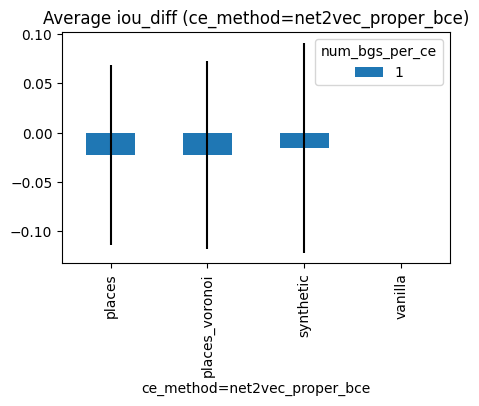

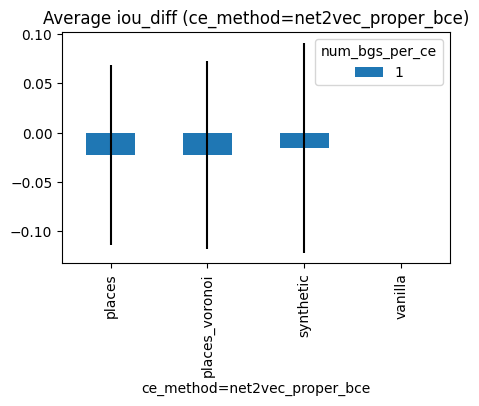

In [ ]:
# plot the direct IoU difference

# Average over the test samples ('img_id' serving as identifying a single ce)
avg_ious_vanilla = ious[ious[TEST_BG] == VANILLA]\
    .groupby([*DERIVED_SETTINGS, *EXPERIMENT_SETTING_COLS, IMG_ID])[IOU].mean().reset_index()
# Some sanity check: Are there duplicate entries for some experiments? If not, we can drop the 'img_id'.
assert avg_ious_vanilla.groupby(by=[s for s in EXPERIMENT_SETTING_COLS if s != BG]).apply(
    lambda d: len(d[BG].unique()) == len(d[BG].index), include_groups=False).all()

diffs = avg_ious_vanilla
# group such columns = [ 'bg_randomizer_key', 'iou' ]
diffs = diffs.groupby(by=[s for s in EXPERIMENT_SETTING_COLS if s != BG])
# calculate for each
diffs = diffs.apply(lambda d: pd.DataFrame({BG: d[BG], 'iou_diff': (d[IOU] - d[d[BG] == VANILLA][IOU].max())}),
                    include_groups=False)
diffs = diffs.reset_index(level=-1, drop=True).reset_index()  #.rename(columns={'iou': 'iou_diff'})

#print(diffs)
plot_means(diffs, 'iou_diff',
           compare=[NUM_BG], group_cols=[BG],
           side_by_side=[CE_METHOD])